# Convolutional Networks

In [6]:
# Setup
import tensorflow as tf
import keras

import numpy as np

import time as timer
import datetime

import os
import sys
import imp

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import models as M

imp.reload(M)

<module 'models' from '/Users/mghifary/Work/Code/AI/keras-poc/models.py'>

### Constants

In [7]:
EPOCH = 20
BATCH = 64

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

modelpath = os.path.join(MODELDIR, "mnist-lenet-classifier.h5")

In [8]:
# Load dataset
data_path = os.path.join(DATADIR, "mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(data_path)
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

(n_train, dx1, dx2) = x_train.shape
n_test = x_test.shape[0]

x_train = np.reshape(x_train, (-1, dx1, dx2, 1))
x_test = np.reshape(x_test, (-1, dx1, dx2, 1))

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle and batch
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH)
dataset_test = dataset_test.batch(BATCH)

In [9]:
# Build model
model = M.LeNet5(num_classes=10, input_shape=(dx1, dx2, 1))
model.build(input_shape=(None, dx1, dx2, 1))
model.summary()

Model: "le_net5_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           multiple                  832       
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           multiple                  38448     
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  30

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           832       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  multiple                     0         ['conv2d[0][0]',              
 D)                                                                  'conv2d_1[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 10, 48)           38448     ['max_pooling2d[0][0]']   

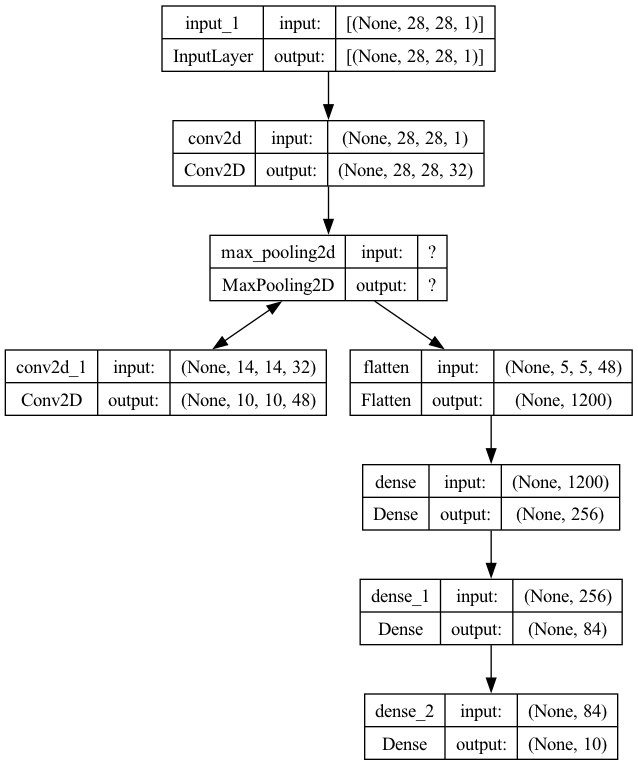

In [5]:
# Plot model
inputs = keras.Input(shape=(dx1, dx2, 1))
model_func = keras.Model(inputs, model.call(inputs))
print(model_func.summary())
modelfig_path = os.path.join(MODELDIR, "conv_mnist.png")
keras.utils.plot_model(model_func, to_file=modelfig_path, show_shapes=True)

Train model

In [5]:
# Loss and optimizer
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=3e-4)


In [6]:
# Define metrics
train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = keras.metrics.SparseCategoricalAccuracy('train_accuracy')

test_loss = keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [7]:
# Training and test function
@tf.function
def train_on_batch(model, loss_fn, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_loss(loss_value)
    train_accuracy(y, y_pred)

@tf.function
def test_on_batch(model, loss_fn, x, y):
    y_pred = model(x, training=False)
    loss_value = loss_fn(y, y_pred)
    
    test_loss(loss_value)
    test_accuracy(y, y_pred)

In [8]:
# Setup summary writers
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/convnet-mnist/' + current_time + '/train'
test_log_dir = 'logs/convnet-mnist/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [9]:
# Do training
for epoch in range(EPOCH):
    # Mini-batch training
    train_duration = 0.0
    for step, (x, y) in enumerate(dataset):
        start_t = timer.time()
        train_on_batch(model, loss_fn, optimizer, x, y)
        elapsed_t = timer.time() - start_t

        train_duration += elapsed_t
    
    # Store log
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    # Test
    test_duration = 0.0
    for step, (xt, yt) in enumerate(dataset_test):
        start_t = timer.time()
        test_on_batch(model, loss_fn, xt, yt)
        elapsed_t = timer.time() - start_t

        test_duration += elapsed_t

    # Store log
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    print(f"Epoch {epoch+1} - Training [loss: {train_loss.result():.5f}, accuracy: {train_accuracy.result():.3f}] ({train_duration:.3f} secs), Test [loss: {test_loss.result():.5f}. accuracy: {test_accuracy.result():.3f}] ({test_duration:.3f} secs)")

    # Save model
    model.save_weights(modelpath, overwrite=True, save_format=None, options=None)

# end of epoch

Epoch 1 - Training [loss: 0.22991, accuracy: 0.935] (12.202 secs), Test [loss: 0.07712. accuracy: 0.975] (0.728 secs)
Epoch 2 - Training [loss: 0.14744, accuracy: 0.958] (12.250 secs), Test [loss: 0.06114. accuracy: 0.980] (0.713 secs)
Epoch 3 - Training [loss: 0.11313, accuracy: 0.967] (12.998 secs), Test [loss: 0.05282. accuracy: 0.983] (0.622 secs)
Epoch 4 - Training [loss: 0.09312, accuracy: 0.973] (12.167 secs), Test [loss: 0.04920. accuracy: 0.984] (0.888 secs)
Epoch 5 - Training [loss: 0.07960, accuracy: 0.977] (13.977 secs), Test [loss: 0.04649. accuracy: 0.985] (0.906 secs)
Epoch 6 - Training [loss: 0.06979, accuracy: 0.980] (14.048 secs), Test [loss: 0.04412. accuracy: 0.986] (0.704 secs)
Epoch 7 - Training [loss: 0.06223, accuracy: 0.982] (13.871 secs), Test [loss: 0.04195. accuracy: 0.986] (0.645 secs)
Epoch 8 - Training [loss: 0.05594, accuracy: 0.984] (14.097 secs), Test [loss: 0.04045. accuracy: 0.987] (1.072 secs)
Epoch 9 - Training [loss: 0.05098, accuracy: 0.985] (15.